# Guiding questions

What fields of study are international students in the U.S. entering?

In [1]:
from collections import defaultdict
from fuzzywuzzy import fuzz, process
from bs4 import BeautifulSoup, Tag
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests

In [59]:
fields = [
    'agriculture',
    'business and management',
    'communications and journalism',
    'education',
    'engineering',
    'fine and applied arts',
    'health professions',
    'humanities',
    'intensive english',
    'legal studies and law enforcement',
    'math and computer science',
    'physical and life sciences',
    'social sciences',
]
years = [y for y in range(1999, 2016)]

In [60]:
def getYearTable(year):
    yr = year
    if year == 2015:
        yr -= 1
    r = requests.get(
        'https://www.iie.org/Research-and-Insights/Open-Doors/Data/International-Students' + 
        f'/Fields-of-Study/Fields-of-Study/{yr}-{str(yr+2)[-2 if yr > 1999 else 0:]}'
    )
    table = BeautifulSoup(r.content).table
    table.tr.decompose()
    df = pd.read_html(str(table))[0]
    columns = df.iloc[0].str.lower()
    columns[2 if year == 2015 else 1] = 'population' # rename column we want to Population
    df.columns = columns
    df = df.reindex(df.index.drop(0))
    df = df.dropna(subset=['field of study']) # drop columns with NaN fields
    df['field of study'] = df['field of study'].str.lower().str.replace(', total', '')
    return df

In [61]:
tables = {year: getYearTable(year) for year in years}

In [66]:
fieldPopulations = {f: [] for f in fields}

for field in fields:
    for year in years:
        table = tables[year]
        tableFields = list(table['field of study'].unique())
        match, score = process.extractOne(field, tableFields, scorer=fuzz.partial_ratio)
        if score < 84: # experimentally derived/hard-coded bad score
            fieldPopulations[field].append(0)
        else:
            fieldPopulations[field].append(
                int(table[table['field of study'] == match].iloc[0]['population'])
            )

In [70]:
# sum all field populations for calculating proportions
yearTotals = []
for i in range(len(years)):
    yearTotals.append(
        sum([ fieldPopulations[field][i] for field in fields ])
    )

# calculate proportions
fields = sorted(fields, key=lambda f: max(fieldPopulations[f]), reverse=True)
proportions = {
    f: [(fieldPopulations[f][i] or 0) / yearTotals[i] for i in range(len(years))] for f in fields
}

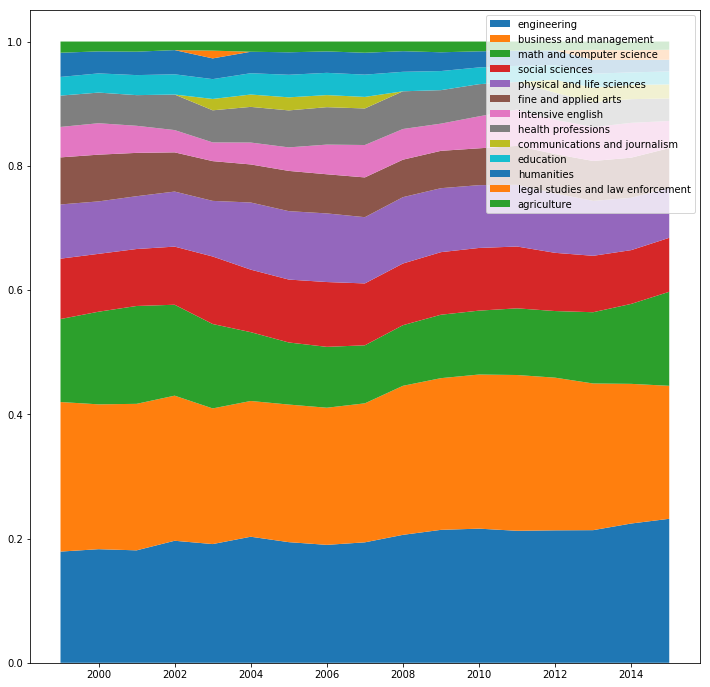

In [71]:
stacks = list(proportions.values())
labels = list(proportions.keys())

plt.figure(figsize=(12, 12))
plt.stackplot(years, stacks, labels=labels)
plt.legend()

# Findings